## Project: **Vehicle Detection** 
# P5



## Import Packages

In [42]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


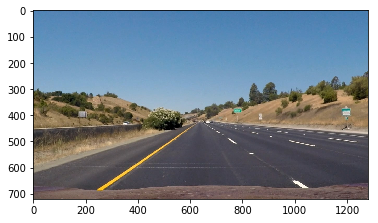

In [43]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [44]:
img_size = image.shape
print(image.shape)
max_x = image.shape[1]
max_y = image.shape[0]

(720, 1280, 3)


## Camera Calibration

Calibrate the camera with the given images


In [45]:
# prepare object points
nx = 9 #number of inside corners in x
ny = 6 #number of inside corners in y

objpoints = []
imgpoints = []
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

for fname in images:
    img = cv2.imread(fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #plt.imshow(img)

In [46]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## Tune the parameters

In this section, we will use one image of a straight road to get all the parameters related to the perspective changes and lane finding.

We will tune those parameters to try to achieve the best lane extraction.




In [47]:
# Transform a RGB image into a HLS image
def extract_s_channel_from_BGR(img):
    '''img must be a BGR image'''
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    return hls[:,:,2]
def extract_s_channel_from_RGB(img):
    '''img must be a BGR image'''
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return hls[:,:,2]

In [48]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    if len(img.shape) > 2:
        # it's an BGR image so convert it to gray
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img
    if orient == 'x':
        sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    if len(img.shape) > 2:
        # it's an BGR image so convert it to gray
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    sobel_mag = np.sqrt(np.power(sobelx,2)+np.power(sobely,2))
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    if len(img.shape) > 2:
        # it's an BGR image so convert it to gray
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img
    abs_sobelx = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    grad_direction = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(grad_direction)
    dir_binary[(grad_direction >= thresh[0]) & (grad_direction <= thresh[1])] = 1
    return dir_binary


In [49]:
def apply_gradients (img, ksize=3):
    x_thresh = (40, 120)
    y_thresh = (50, 200)
    mag_thresh_=(60, 180)
    g_thresh = (0.7, 1.3)
    gradx_sChannel = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=x_thresh)
    grady_sChannel = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=y_thresh)
    mag_binary_sChannel = mag_thresh(img, sobel_kernel=ksize, mag_thresh=mag_thresh_)
    dir_binary_sChannel = dir_threshold(img, sobel_kernel=ksize, thresh=g_thresh)
    
    combined_sChannel = np.zeros_like(dir_binary_sChannel)
    combined_sChannel[((gradx_sChannel == 1) & (grady_sChannel == 1)) | ((mag_binary_sChannel == 1) & (dir_binary_sChannel == 1))] = 1
    
    return combined_sChannel

In [50]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

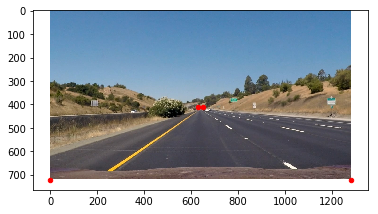

In [51]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')

# vertices of the polygon
th = 10 #pixels
edge_upper_left = [int(max_x/2)-th,int(max_y/2)+50]
edge_upper_right = [int(max_x/2)+th,int(max_y/2)+50]
edge_lower_left =[0,max_y]
edge_lower_right = [max_x,max_y]
vertices = np.array([edge_upper_left,edge_upper_right,edge_lower_right,edge_lower_left])

# check that they make sense
x_array = [int(max_x/2)-th,int(max_x/2)+th,0,max_x]
y_array = [int(max_y/2)+50, int(max_y/2)+50,max_y, max_y ]
implot = plt.imshow(image)
# put a red dot, size 40, at 2 locations:
plt.scatter(x=x_array, y=y_array, c='r', s=20)
plt.show()

## Perspective change --> Bird view

For this section, we need to use an image for which the camera calibration has been applied as it will be how the pipeline will work.

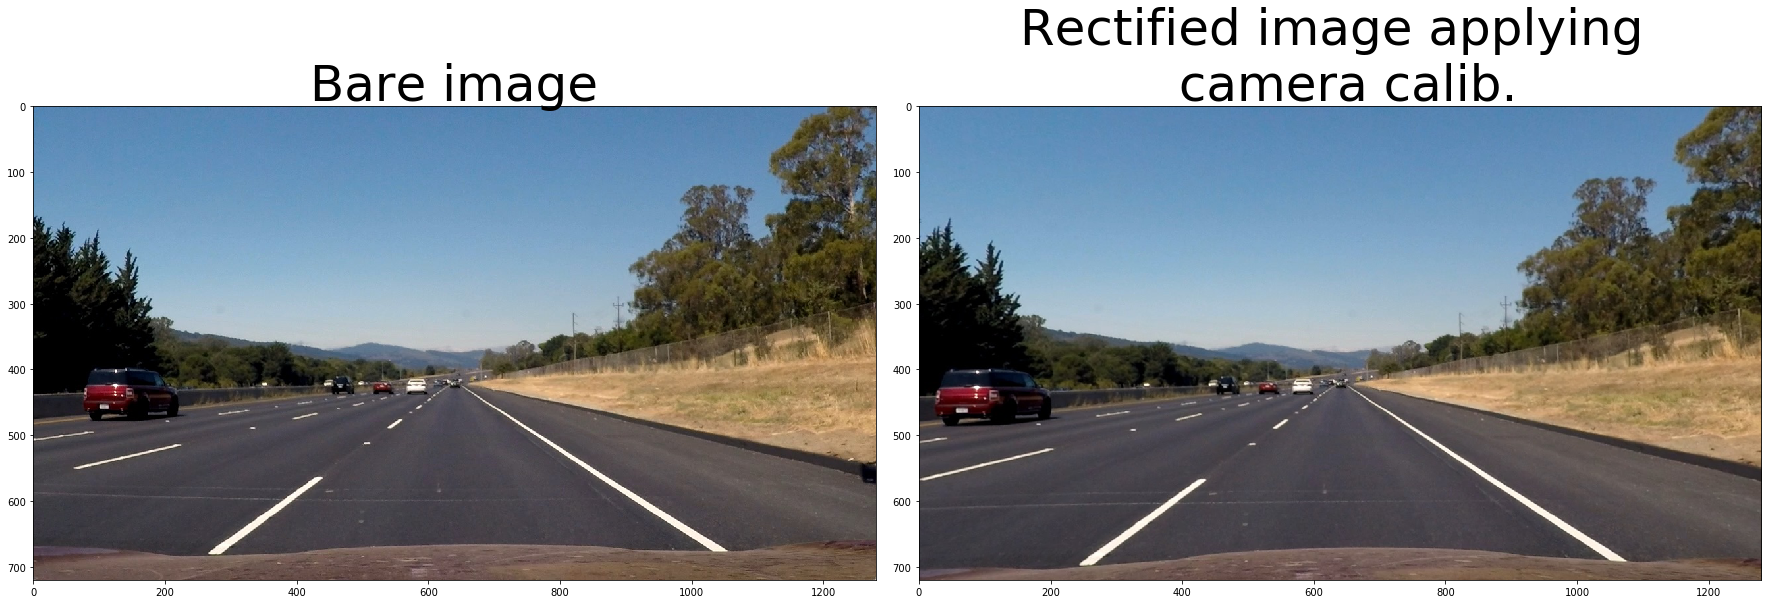

In [52]:
#reading in an image
image = mpimg.imread('test_images/straight_lines2.jpg')

undistorted = cv2.undistort(image, mtx, dist, None, mtx)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Bare image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Rectified image applying \n camera calib.',fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

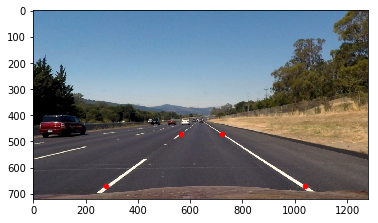

[[  564.   470.]
 [  723.   470.]
 [  280.   670.]
 [ 1040.   670.]]


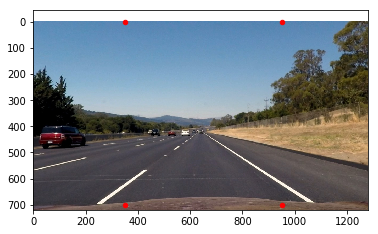

[[ 350.    0.]
 [ 950.    0.]
 [ 350.  700.]
 [ 950.  700.]]


In [83]:
# find the source and destination points
# source points

#longer distance
x_array = [564,max_x - 557,280,max_x-240]
y_array = [470, 470,max_y-50, max_y-50 ]
#shorter distance
#x_array = [515,max_x - 510,275,max_x-240]
#y_array = [500, 500,max_y-50, max_y-50 ]
#plot the source points to make sure they make sense
implot = plt.imshow(undistorted)
plt.scatter(x=x_array, y=y_array, c='r', s=20)
plt.show()

src = np.empty(shape = (4,2), dtype = np.float32)
for i, (x, y) in enumerate(zip(x_array, y_array)):
    pt = [x,y]
    src[i] = pt
print(src)

# destination points
dst = np.empty(shape = (4,2), dtype = np.float32)
x_array_dst = [350,950, 350, 950]
y_array_dst = [0, 0, 700, 700 ]
#plot the source points to make sure they make sense
implot = plt.imshow(undistorted)
plt.scatter(x=x_array_dst, y=y_array_dst, c='r', s=20)
plt.show()
for i, (x, y) in enumerate(zip(x_array_dst, y_array_dst)):
    pt = [x,y]
    dst[i] = pt
print(dst)

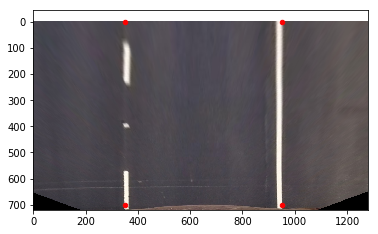

In [84]:
img = undistorted
img_size = (img.shape[1], img.shape[0])

M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)
implot = plt.imshow(warped)
plt.scatter(x=x_array_dst, y=y_array_dst, c='r', s=20)
plt.show()

 ## Create the pipeline
 
 Now that we have computed the camera calibration and found the matrix needed to change the perspective of an image, we can call them in a function that processes the image in the following way: 
 * Apply the camera calibration to the incoming image
 * Apply the gradient function to isolate the lanes
 * Truncate the image to the 'zone of interest'
 * Change the perspective to a bird view
 * Identify the lanes
 * Find a fit for the lanes

In [55]:
def region_of_interest_binary(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [56]:
def transform_image(img, calib_matrix, dist_coeffs, brid_view_transform):
    img_size = (img.shape[1], img.shape[0])
    # apply camera calibration on the image
    undistorted_img = cv2.undistort(img, calib_matrix, dist_coeffs, None, calib_matrix)
    # extract_s_channel_from_BGR
    sChannel_img = extract_s_channel_from_RGB(undistorted_img)
    # apply all the gradients function
    grad_img = apply_gradients(sChannel_img, ksize=15)
    grad_img[grad_img>0]=255
    # truncate image to region of interest
    truncated_image = region_of_interest_binary(grad_img, [vertices])
    truncated_image[truncated_image>0]=1
    # change perspective
    bird_view_img = cv2.warpPerspective(truncated_image, brid_view_transform, img_size, flags=cv2.INTER_LINEAR)
    bird_view_img[bird_view_img>0]=1.0
    return bird_view_img

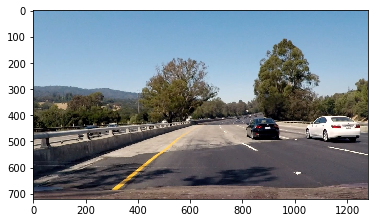

(720, 1280)


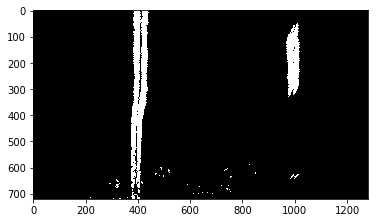

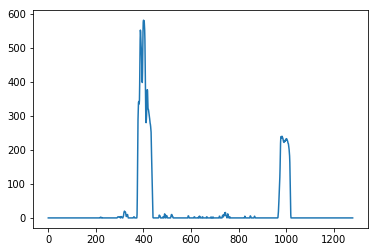

In [57]:
# read an image
image_rot = mpimg.imread('test_images/test4.jpg')
plt.imshow(image_rot)
plt.show()
b = transform_image(image_rot, mtx, dist, M)

print(b.shape)
plt.imshow(b, cmap='gray')
plt.show()

histogram = np.sum(b[img.shape[0]//2**3:,:], axis=0)
plt.plot(histogram)
plt.show()

In [58]:
class Line():
    def __init__(self):
        # is it the first time we detect a lane?
        self.first_detection = True
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None 
        #polynomial coefficients for the last fit
        self.previous_fit = None 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.undetected_counter = 0
        

left_lane = Line()
left_lane.type = 'left'
right_lane = Line()
right_lane.type = 'right'

In [145]:
binary_warped = b 

def first_time_lane_search(birdview_binary_frame, left_lane, right_lane):
    '''
    Use a sliding window method to detect the lanes.
    return the left and right polyfit of the lanes as well as the image
    showing the birdwiew with the lanes
    '''
    # Take a histogram of the bottom half of the image
    histogram = np.sum(birdview_binary_frame[birdview_binary_frame.shape[0]//2**3:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((birdview_binary_frame, birdview_binary_frame, birdview_binary_frame))

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(birdview_binary_frame.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = birdview_binary_frame.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = birdview_binary_frame.shape[0] - (window+1)*window_height
        win_y_high = birdview_binary_frame.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,1,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,1,0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    try:
        right_fit = np.polyfit(righty, rightx, 2)
    except TypeError:
        right_fit = np.array([0,0,0], dtype='float') 

    
    # Generate x and y values for plotting
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]
    
    # populate the lanes elements with the values extracted from this frame
    left_lane.allx = leftx
    left_lane.ally = lefty
    right_lane.allx = rightx
    right_lane.ally = righty
    
    left_lane.current_fit = left_fit
    right_lane.current_fit = right_fit
    
    return left_fit, right_fit, out_img

def smart_lane_search(birdview_binary_frame, left_lane, right_lane):
    '''In this function, we assume that the lanes were previously detected and we can re-use this
    information to quickly detect the next lanes'''
    nonzero = birdview_binary_frame.nonzero()
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((birdview_binary_frame, birdview_binary_frame, birdview_binary_frame))
    
    left_fit = left_lane.previous_fit
    right_fit = right_lane.previous_fit
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 200
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Generate x and y values for plotting
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]
    # Fit a second order polynomial to each
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except TypeError:
        plt.imshow(out_img, cmap='gray')
        plt.show
        sys.exit()
    # Generate x and y values for plotting
    ploty = np.linspace(0, birdview_binary_frame.shape[0]-1, birdview_binary_frame.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # populate the lanes elements with the values extracted from this frame
    left_lane.allx = leftx
    left_lane.ally = lefty
    right_lane.allx = rightx
    right_lane.ally = righty
    
    left_lane.current_fit = left_fit
    right_lane.current_fit = right_fit
    
    return out_img

(720, 0)

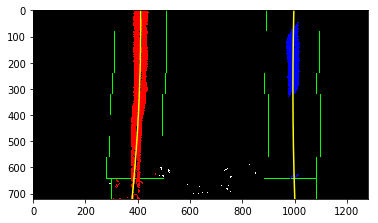

In [60]:
binary_warped = b 

left_fit, right_fit, out_img = first_time_lane_search(binary_warped, left_lane, right_lane)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [118]:
def value_from_polyfit(ployfit_array_deg2, x):
    return ployfit_array_deg2[0]*x**2 + ployfit_array_deg2[1]*x + ployfit_array_deg2[2]

def plot_lanes(image, birdview_binary, left_lane, right_lane, M_inv):
    '''Image is the undistorted image provided by the video
    Use the current_fit for the lanes'''
    font = cv2.FONT_HERSHEY_SIMPLEX
    # Generate x and y values for plotting
    ploty = np.linspace(0, birdview_binary.shape[0]-1, birdview_binary.shape[0] )
    left_fitx = value_from_polyfit(left_lane.best_fit, ploty)
    right_fitx =  value_from_polyfit(right_lane.best_fit, ploty)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(birdview_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    distance = left_lane.line_base_pos
    text_rad ='Radius of curvature = '+ str(left_lane.radius_of_curvature) + ' m'
    text_center = 'Vehicle is '+ str(distance) + ' m away from center'
    result = cv2.putText(result,text_rad,(50,50), font, 1,(0,0,0),2,cv2.LINE_AA)
    result = cv2.putText(result,text_center,(50,80), font, 1,(0,0,0),2,cv2.LINE_AA)
    plt.imshow(result)
    return result

In [62]:
#plot_lanes(image_rot, binary_warped, left_lane, right_lane, M_inv)

Calculate the radius of curvature

In [113]:
def calculate_curvature_radius(polyfit, point):
    a = np.power((2*polyfit[0]*point+polyfit[1]),2)
    radius = np.power(1+a,3/2)/np.absolute(2*polyfit[0])
    return radius

def calculate_curvature_radius_px_to_m(lane, point):
    '''Calculate the radii of curvature fora given lane 
    equations and returns the results in meters without decimal values'''
    ym_per_pix =15/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/600 # meters per pixel in x dimension
    x_points = lane.allx
    y_points = lane.ally
    # Fit new polynomials to x,y in world space
    polyfit_m = np.polyfit(y_points*ym_per_pix, x_points*xm_per_pix, 2)
    # Calculate the new radii of curvature
    return np.around(calculate_curvature_radius(polyfit_m, point*ym_per_pix))

def calculate_vehicle_position(lane, point = 720):
    xm_per_pix = 3.7/600
    if lane.type == 'left':
        distance_px = abs(value_from_polyfit(lane.current_fit, point)-350)
    else:
        distance_px = abs(value_from_polyfit(lane.current_fit, point)-950)
    distance_meter = np.around(xm_per_pix*distance_px, decimals =2)
    return distance_meter

In [122]:
def lanes_correctly_detected(lane_left, lane_right, img_size,  min_lane_distance = 450):
    y_max = img_size[1]
    distance_between_lanes_OK = None
    if lane_correctly_detected(lane_left, img_size) and lane_correctly_detected(lane_right, img_size):
        if is_distance_between_lane_normal(lane_left, lane_right, img_size,  min_lane_distance):
            if abs(calculate_delta_radius(lane_left, img_size)) < 3500 and abs(calculate_delta_radius(lane_right, img_size)) < 3500 :
                return True
            else:
                if abs(calculate_delta_radius(lane_left, img_size)) > 3500:
                    previous_radius = lane_left.radius_of_curvature
                    new_radius = calculate_curvature_radius_px_to_m(lane_left, img_size[1])
                else:
                    previous_radius = lane_right.radius_of_curvature
                    new_radius = calculate_curvature_radius_px_to_m(lane_right, img_size[1])
                if previous_radius is not None:
                    if abs(previous_radius) > 10000 or abs(new_radius) > 10000:
                        return True
                    else:
                        return False
                else:
                    return True
        else:
            return False
    else:
        return False
    
def left_lane_correctly_detected(lane, img_size):
    y_max = img_size[1]
    x_max = img_size[0]
    polyfit = lane.current_fit
    # x_low >500 or curvature < 130 it is probably not a good detection
    if value_from_polyfit(polyfit, y_max)>550 or calculate_curvature_radius_px_to_m(lane, y_max)<130:
        #print('not a lane')
        return False
    else:
        return True
        
def lane_correctly_detected(lane, img_size):
    y_max = img_size[1]
    x_max = img_size[0]
    polyfit = lane.current_fit
    if lane.type == 'left':
        # x_low >500 or curvature < 130 it is probably not a good detection
        if value_from_polyfit(polyfit, y_max)>550 or calculate_curvature_radius_px_to_m(lane, y_max)<130:
            #print('not a lane')
            return False
        else:
            return True
    else:
        # x_low >500 or curvature < 130 it is probably not a good detection
        if value_from_polyfit(polyfit, y_max)<700 or calculate_curvature_radius_px_to_m(lane, y_max)<130:
            #print('not a lane')
            return False
        else:
            return True

def is_distance_between_lane_normal(left_lane, right_lane, img_size,  min_lane_distance = 450):
    y_max = img_size[1]
    y_middle = y_max/2
    # => check at y = 0 & y = y_max that the lanes seem well spaced
    lane_distance_OK = None
    x_left_low = value_from_polyfit(left_lane.current_fit, y_max)
    x_right_low = value_from_polyfit(right_lane.current_fit, y_max)
    delta_low = x_right_low - x_left_low
    if delta_low < 0:
        return False
    else:
        if delta_low > min_lane_distance:
            x_left_upper = value_from_polyfit(left_lane.current_fit, 0)
            x_right_upper = value_from_polyfit(right_lane.current_fit, 0)
            delta_upper = x_right_upper - x_left_upper
            if delta_upper < 0:
                return False
            elif delta_upper > 600 :
                #print('delta_upper too large')
                return False
            else:
                x_left_middle = value_from_polyfit(left_lane.current_fit, y_middle)
                x_right_middle = value_from_polyfit(right_lane.current_fit, y_middle)
                delta_middle = x_right_middle - x_left_middle
                if delta_middle < 550:
                    # print('delta_middle too small')
                    return False
                if delta_middle > 680:
                    # print('delta_middle too big')
                    return False
                else:
                    return True

def calculate_delta_radius(lane, img_size):
    if lane.first_detection == True:
        delta_curvature_radius = calculate_curvature_radius_px_to_m(lane, img_size[1])
    else:
        delta_curvature_radius = lane.radius_of_curvature
        new_radius_of_curvature = calculate_curvature_radius_px_to_m(lane, img_size[1])
        delta_curvature_radius = delta_curvature_radius - new_radius_of_curvature
    #print('delta ',lane.type , delta_curvature_radius)
    return delta_curvature_radius

In [65]:
print(lane_correctly_detected(right_lane, [1280,720]))

True


In [66]:
def update_lane_when_detected(lane, img_size):
    lane.detected = True
    lane.radius_of_curvature = calculate_curvature_radius_px_to_m(lane, img_size[1])
    lane.line_base_pos = calculate_vehicle_position(lane, img_size[1])
    if lane.first_detection == True:
        lane.first_detection = False
        lane.best_fit = lane.current_fit
    else:
        lane.diffs=lane.previous_fit-lane.current_fit
        previous_best_fit = lane.best_fit*0.4
        current_weighted_fit = lane.current_fit*0.6
        e = np.concatenate((previous_best_fit,current_weighted_fit),axis=0).reshape(2,3)
        lane.best_fit =  np.sum(e, axis=0) 
    lane.previous_fit = lane.current_fit
    lane.current_fit = None 
    lane.undetected_counter = 0

def update_lane_when_not_detected(lane):
    lane.detected = False
    lane.current_fit = None
    lane.undetected_counter += 1

In [121]:
import sys
def lane_search_and_check (image, birdview_binary, left_lane, right_lane, counter):
    if counter < 2:
        if left_lane.detected == False or right_lane.detected == False:
            # call the window scanning function 
            first_time_lane_search(birdview_binary, left_lane, right_lane)
            # if the lanes pass the first sanity check
            if lanes_correctly_detected(left_lane, right_lane, img_size):
                # we strongly think we have a lane
                # update right_lane and left_lane to reflect that we correctly detected a lane
                update_lane_when_detected(left_lane, img_size)
                update_lane_when_detected(right_lane, img_size)
                # get the image to output for the video
                #print('success1')
                return plot_lanes(image, birdview_binary, left_lane, right_lane, M_inv)
                
            else: # one of the two lane is not well detected
                #use the previous lane info and check which one of the lane polyfit or radii is close to its previous value
                #print('One of 2 lanes not well detected')
                if left_lane.first_detection == True:
                    return image
                else:
                    #update_lane_when_not_detected(left_lane)
                    if left_lane_correctly_detected(left_lane, img_size):
                        update_lane_when_detected(left_lane, img_size)
                    else:
                        update_lane_when_not_detected(left_lane)
                    update_lane_when_not_detected(right_lane)
                    return plot_lanes(image, birdview_binary, left_lane, right_lane, M_inv)
        else: # we succesfully detected a lane in the previous frame
            # run the smart detection
            out_img = smart_lane_search(birdview_binary, left_lane, right_lane)
            #make sure that the lanes were detected OK
            if  lanes_correctly_detected(left_lane, right_lane, img_size):
                # we strongly think we have a lane
                # update right_lane and left_lane to reflect that we correctly detected a lane
                update_lane_when_detected(left_lane, img_size)
                update_lane_when_detected(right_lane, img_size)
                # get the image to output for the video
                #print('success2')
                return plot_lanes(image, birdview_binary, left_lane, right_lane, M_inv)
            # if not, try the window detection 
            else:
                #print('back to window detection')
                update_lane_when_not_detected(left_lane)
                update_lane_when_not_detected(right_lane)
                counter +=1
                # recursively call the function to re-run the search
                return lane_search_and_check(image, birdview_binary, left_lane, right_lane, counter)
    else:
        # we haven't detected a lane and we tried multiple times
        # for now return the image, but maybe return the previous fit instead?
        return image

In [68]:
def detect_lanes(image):
    img_size = [image.shape[1], image.shape[0]]
    counter = 0
    # apply all the correction and return a binary image in bird_view
    birdview_binary = transform_image(image, mtx, dist, M)
    return lane_search_and_check(image, birdview_binary, left_lane, right_lane, counter)

## Test on Videos

In [69]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

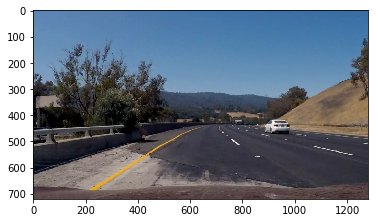

(720, 0)

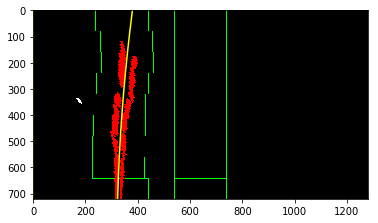

In [146]:
left_lane = Line()
left_lane.type = 'left'
right_lane = Line()
right_lane.type = 'right'
white_output = 'p.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
frame = VideoFileClip("project_video.mp4").get_frame(24.65)
plt.imshow(frame)
plt.show()

binary_warped = transform_image(frame, mtx, dist, M)

left_fit, right_fit, out_img = first_time_lane_search(binary_warped, left_lane, right_lane)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

[MoviePy] >>>> Building video p.mp4
[MoviePy] Writing video p.mp4


100%|█████████▉| 1260/1261 [07:42<00:00,  2.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: p.mp4 

CPU times: user 9min 33s, sys: 2.96 s, total: 9min 36s
Wall time: 7min 43s


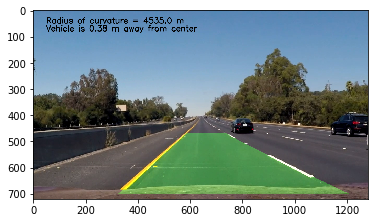

In [147]:
white_clip = clip1.fl_image(detect_lanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.